<center><h1>Pneumonia Detection Challenge</h1></center>
<center><h3>MMM</h3></center>
<br>
<center><img src="https://storage.googleapis.com/kaggle-media/competitions/rsna/Kaggle_Banner.jpg" width=600></img></center> 
<br>

---

### Introduction

For this challenge, we were tasked to create an AI model that can detect pneumonia from x-ray images. To solve this challenge, we had to use the intersection over union (IoU) thresholds to check how precise our model is compared to the given data.
<a id="0"></a>

Intersection over Union is a measure of how big of an overlap between two bounding boxes is. It calculates the size of the overlap between two objects, divided by the total area of the two objects combined.
The IoU of a set of predicted bounding boxes and ground truth bounding boxes is calculated as:


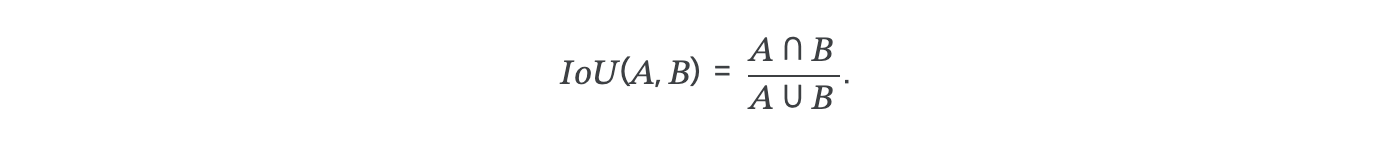
<a id="0"></a>

We also had to calculate the confidence, which is the probability of a detected object belonging to a certain class. In order to identify the class, it was necessary to use bounding boxes to capture the area of where the potential pneumonia might be in a given x-ray. 

For example, we wanted to see the ground truth bounding boxes of the given data by displaying the images as below:

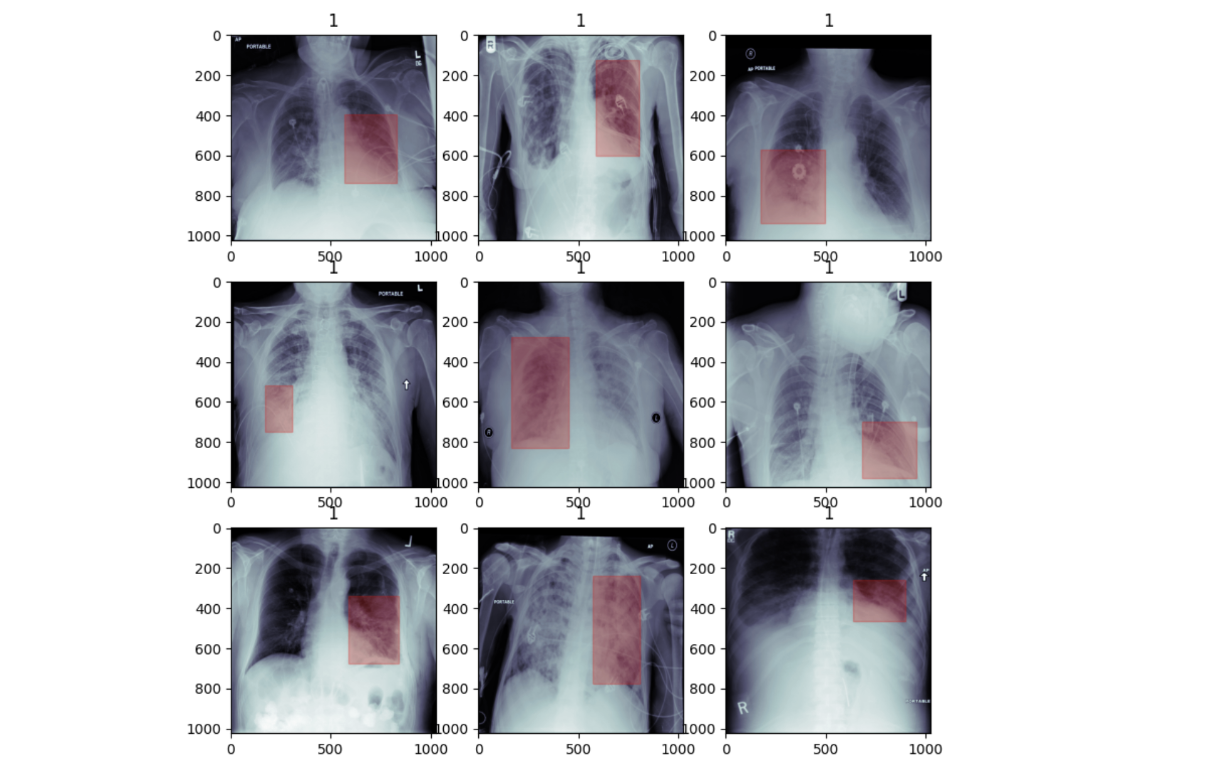

<a id="0"></a>
The data for this challenge contains the following information:

* **stage_2_train.csv** - the training set. Contains patientIds and bounding box / target information;  
* **stage_2_sample_submission.csv** - a sample submission file in the correct format. Contains patientIds for the test set. Note that the sample submission contains one box per image, but there is no limit to the number of bounding boxes that can be assigned to a given image;
* **stage_2_detailed_class_info.csv** - provides detailed information about the type of positive or negative class for each image;

<Data fields - stage_2_detailed_class_info.csv>
* **patientId** - A patientId. Each patientId corresponds to a unique image;
* **x** - the upper-left x coordinate of the bounding box;
* **y** - the upper-left y coordinate of the bounding box;
* **width** - the width of the bounding box;
* **height** - the height of the bounding box;
* **Target** - the binary Target, indicating whether this sample has evidence of pneumonia;


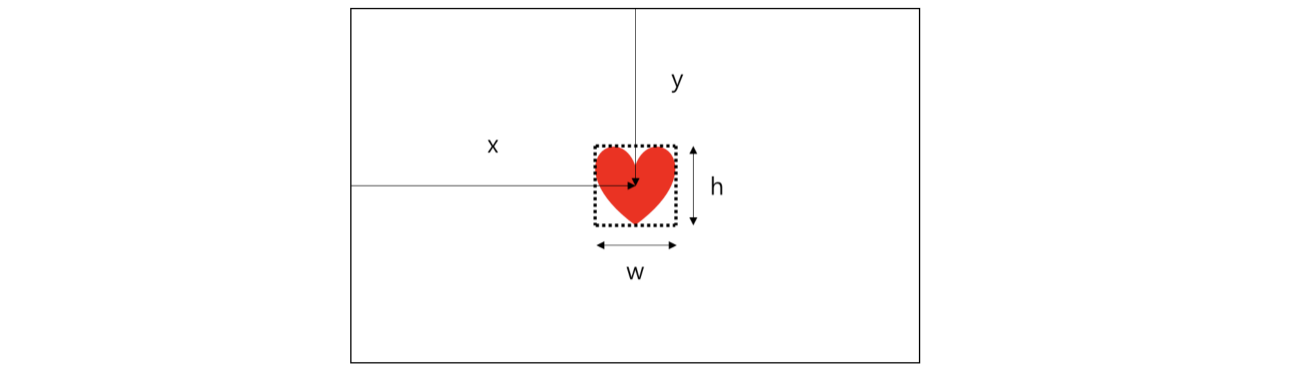


---
### Bounding Box Data Conversion
Since we had to create our own dataset of label.txt files, we had to convert the absolute pixel form that was given in the dataset, to the normalized YOLO format for our model to read.

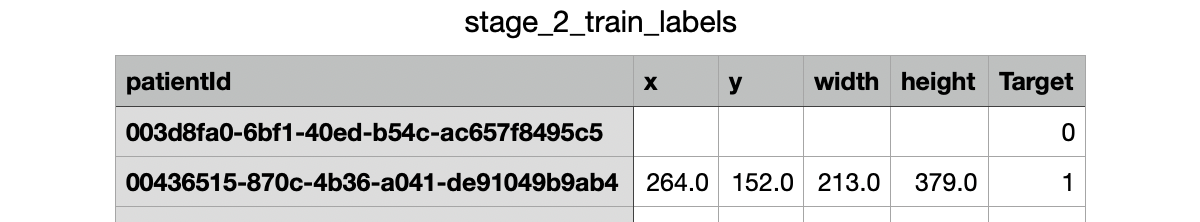
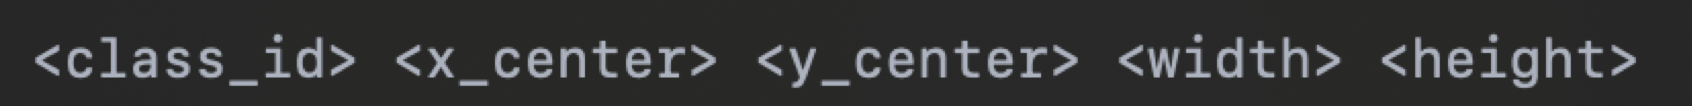

In [ ]:
# relative coordinates
def translate_bbox(bbox):
   img_size = 1024 # rsna defualt image size

   top_left_x = bbox[0]
   top_left_y = bbox[1]
   absolute_w = bbox[2]
   absolute_h = bbox[3]

   relative_w = absolute_w / img_size
   relative_h = absolute_h / img_size

   relative_x = top_left_x / img_size + relative_w / 2
   relative_y = top_left_y / img_size + relative_h / 2

   return relative_x, relative_y, relative_w, relative_h

# absolute coordinates
def revert_bbox(rx, ry, rw, rh):
   img_size = 1024 # rsna defualt image size

   x = (rx-rw/2)*img_size
   y = (ry-rh/2)*img_size
   w = rw*img_size
   h = rh*img_size

   return x, y, w, h

---
### Dataset Structure

To run the code properly, we organized the data into this format to minimize path erros:

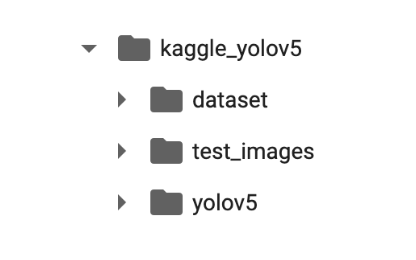

And inside these folders contain:

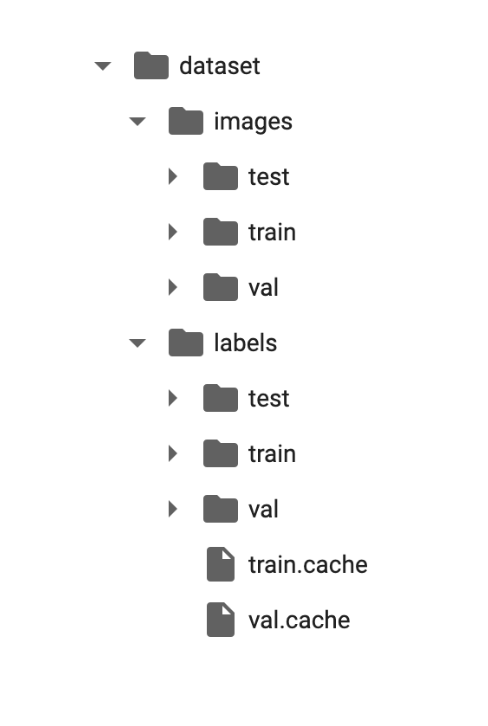
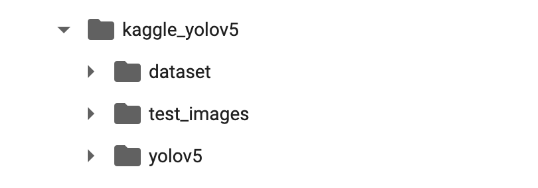
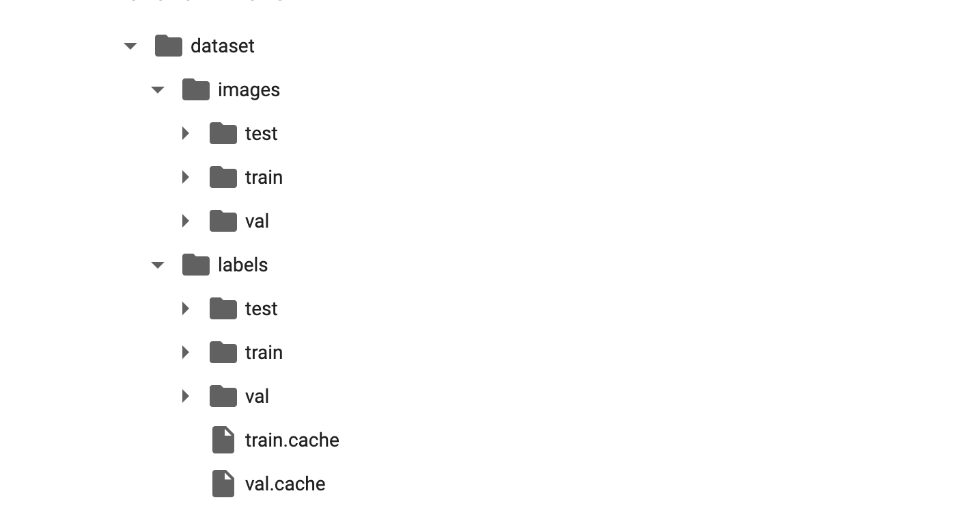

In [ ]:
# We split train and validation data in a 9:1 ratio
train_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=42)

Number of images: 6012

Train set number: 5410

Validation set number: 602

In [ ]:
# All of the images were in dcm format so we had to convert each image to jpeg form for each 
# patientId
for patient_id in tqdm(train_series):
    src_path = train_src_dir + patient_id + ".dcm" # .dcm
    dcm = pydicom.read_file(src_path)
    img_array = dcm.pixel_array # pixel_array
    img = Image.fromarray(img_array)
    img.save(DATASET_DIR + 'images/train/' + patient_id + '.jpg') # .jpg
    
print(len(os.listdir(DATASET_DIR + 'images/train')))

---
### Our Experience with Models
* **CNN (Convolutional neural network)**
  * Simple CNN
  * Deep CNN
  
  
* **ResNet**
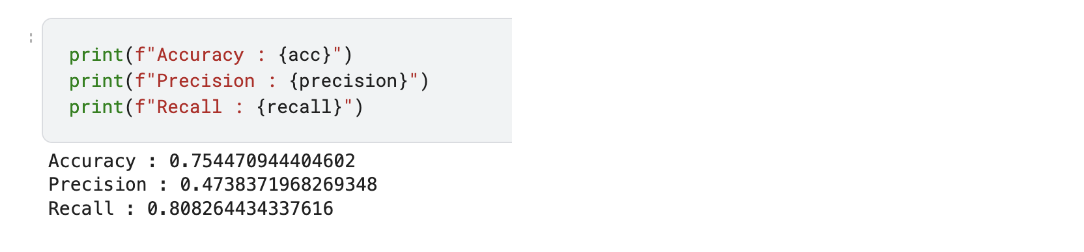
* **YOLO(You Only Look Once)**
    
     Object Detection 알고리즘의 하나로, 입력 이미지에서 다양한 객체를 Bounding Box로 실시간으로 감지하고 분류하는 데 사용
    
    * YOLO v5 Model 종류: Yolov5s, Yolov5m, Yolov5l, Yolov5x
        
         Yolov5s가 제일 가벼운 모델(성능이 낮음)이며 프레임 수가 가장 높고(속도가 빠름), 
         
         Yolov5x가 제일 무거운 모델(성능이 좋음)이며 프레임 수가 가장 낮음

---
### YAML File (YOLO 학습에 사용)
We created a yaml file for our YOLO model to use and train. For the classification, we decided that only was class was necessary for our AI model, which is pneumonia

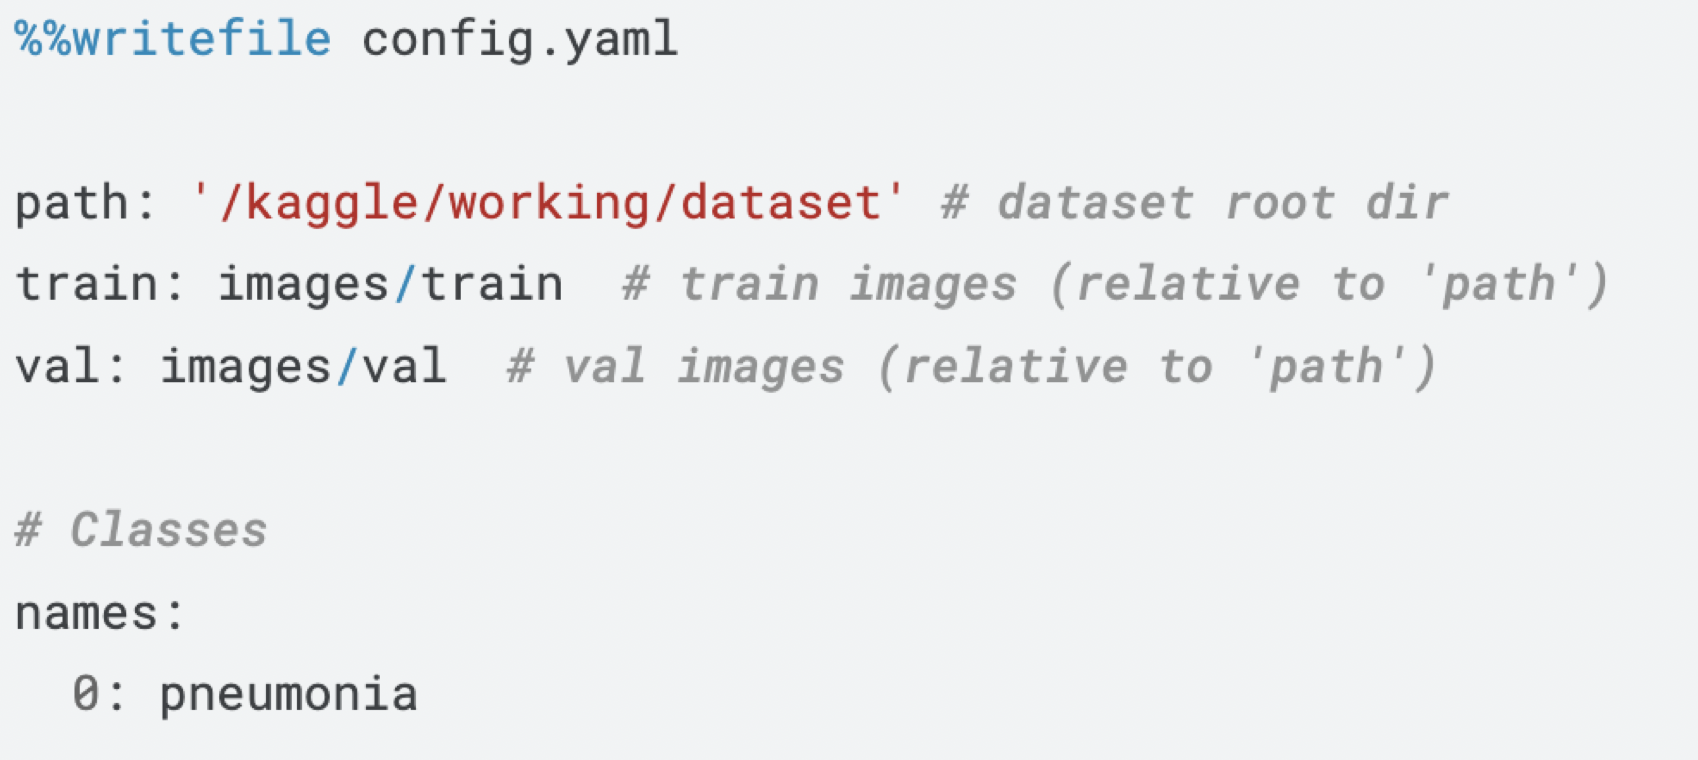

---
### Results Explanation
**1. Image Size (1024 -> 640 -> 480)**
* **1024x1024 (기존 원본 Image Size)**
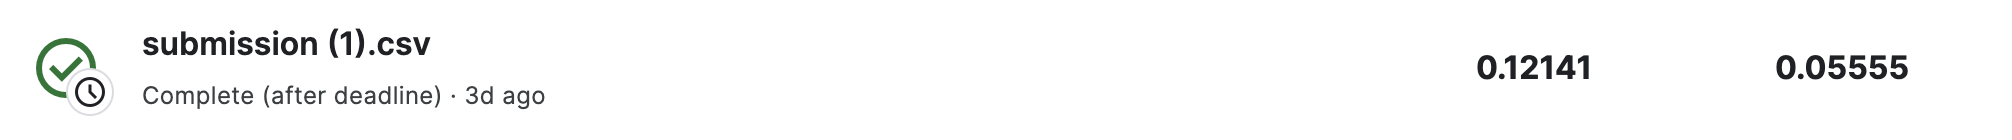

* **640x640**
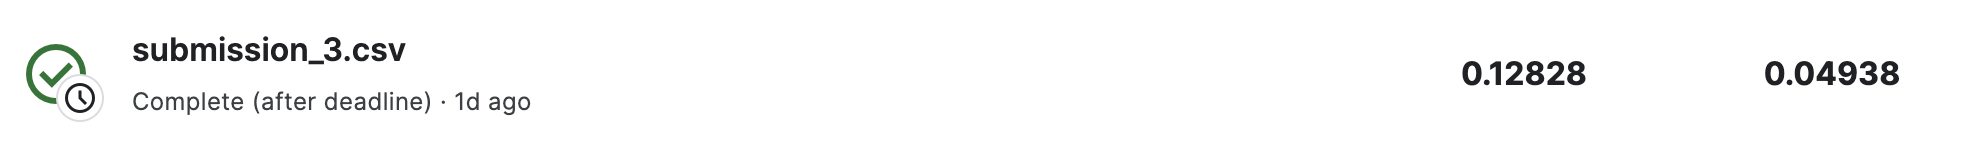

* **480x480**
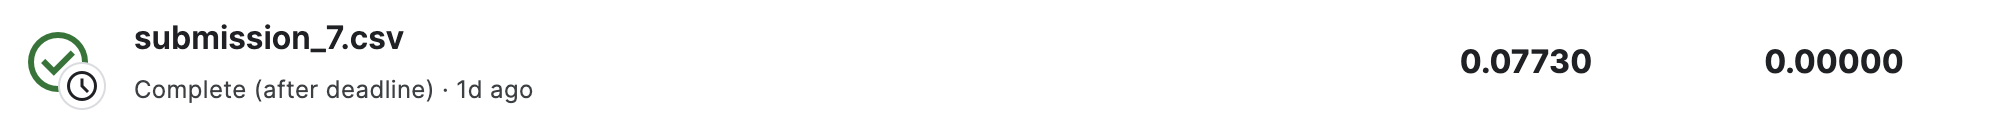

**Analyze:**  학습에 많은 시간이 소요됐던 문제를 해결하고자 이미지 크기를 줄여 시간을 단축했지만 과도하게 이미지 크기를 줄이면 예측의 정확도 감소

**2. batch size**
* **batch size 변경 (16->64)**
   
   **Analyze:** batch size는 16으로 지정해두었고, 64로도 시도해 보았으나 학습에 소요되는 시간이 크게 증가하였고, 그에 반해 결과의 예측 정확도는 크게 높아지지 않았음


**3. epochs**
* **epochs 수 변경**

In [ ]:
results = model.train(data='config.yaml', epochs=3)

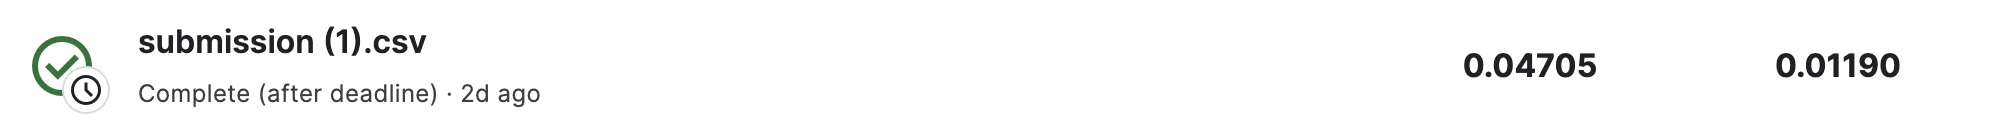

In [ ]:
results = model.train(data='config.yaml', epochs=15)

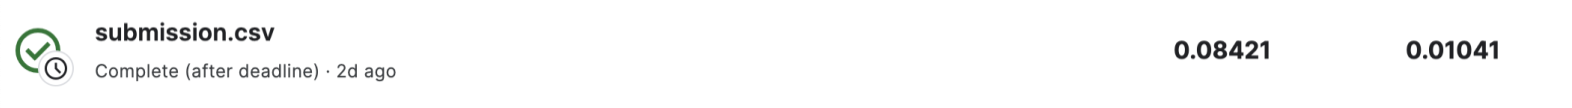

In [ ]:
results = model.train(data='config.yaml', epochs=100)

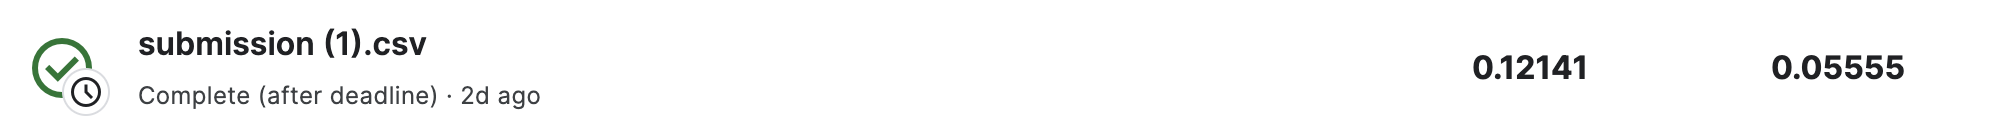

**Analyze:** epochs 크기를 늘려줄수록 score의 상승을 확인할 수 있었음, 하지만 epoch의 크기에 비례해 학습에 걸리는 시간이 오래 걸림

**4. v5 & v8**

**Analyze:** v5을 사용했을 때 loss 값은 더 작게 나왔으나 최종 score는 v8이 더 높은 결과를 얻을 수 있었음

---
***최종 결론 : YOLO v8을 사용해 image size를 적정하게 조정해준 뒤, epochs의 수를 늘려 주는 것이 가장 좋은 결과를 얻을 수 있었음***

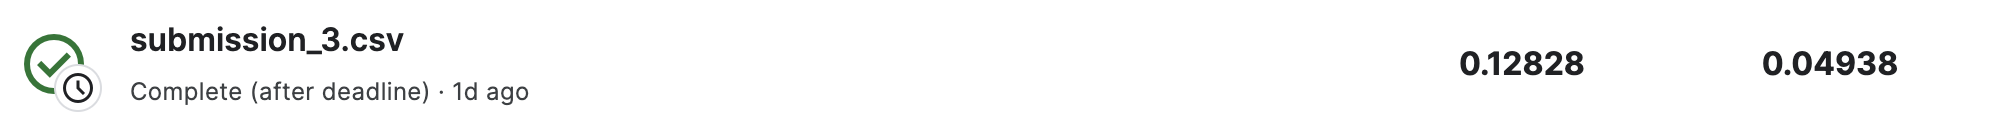